In [1]:
import torch
import matplotlib.pyplot as plt
from polygon import RasLoss, SoftPolygon
from Loader_17 import DAVIS_Rawset
import json
from tenLoader import normalize
import torch.nn as nn
import torch.optim as optim
from MyLoss import get_edges, deviation_loss, total_len_loss

In [2]:
# train_rawset = DAVIS_Rawset(is_train=True)
val_rawset = DAVIS_Rawset(is_train=False)

In [26]:
class BoundarySampler(nn.Module):
    def __init__(
        self,
    ):
        super(BoundarySampler, self).__init__()
        self.boundary_points = nn.Parameter(
            torch.Tensor(
                [
                    [0.0, 0.0],
                    [0.0, 224.0],
                    [224.0, 224.0],
                    [224.0, 0.0],
                ]
            )
        )
        self.hard_polygon = SoftPolygon(0.01, mode="hard_mask")

    def forward(self):
        boundary = self.boundary_points
        boundary = torch.clamp(boundary, 0, 224)
        boundary = boundary.unsqueeze(0)
        return boundary

    def get_numpy(self):
        boundary = self.boundary_points.cpu().detach()
        return boundary

    def get_mask(self):
        boudary = self.forward()
        mask = self.hard_polygon(boudary, 224, 224)
        return mask.squeeze(0).cpu().detach().numpy()

In [27]:
boundary_sampler = BoundarySampler().cuda()

In [28]:
boundary_sampler.boundary_points

Parameter containing:
tensor([[  0.,   0.],
        [  0., 224.],
        [224., 224.],
        [224.,   0.]], device='cuda:0', requires_grad=True)

In [35]:
boundary_sampler.get_mask()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

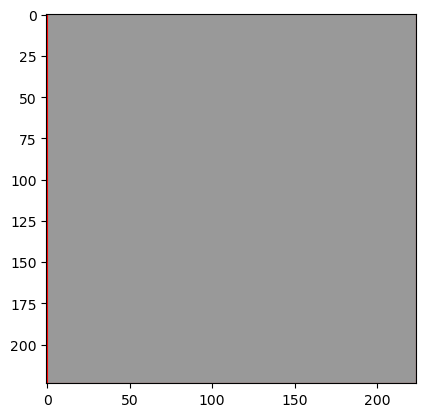

In [36]:
boundary = boundary_sampler.get_numpy()
boundary.shape, boundary
video_idx = 0
frame_idx = 0
img, mask = val_rawset.data_set[video_idx][frame_idx]
plt.subplot(1, 2, 1)
plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.plot(boundary[:, 0], boundary[:, 1], 'r-')
plt.imshow(mask.cpu().numpy(), alpha=0.4)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.show()

In [41]:
def get_cos_loss(pred_bou: torch.Tensor) -> torch.Tensor:
    point_a = pred_bou
    point_b = torch.roll(pred_bou, 1, dims=1)
    point_c = torch.roll(pred_bou, 2, dims=1)

    def get_edge_len(a, b):
        edge_len = torch.sqrt(((a - b) ** 2).sum(dim=2))
        return edge_len

    edge_ab = get_edge_len(point_a, point_b)
    edge_bc = get_edge_len(point_b, point_c)
    edge_ac = get_edge_len(point_a, point_c)
    edge_ab = torch.clamp(edge_ab, min=1e-6)
    edge_bc = torch.clamp(edge_bc, min=1e-6)
    edge_ac = torch.clamp(edge_ac, min=1e-6)
    cos_ac = (edge_ab**2 + edge_bc**2 - edge_ac**2) / (2 * edge_ab * edge_bc)
    cos_ac = torch.clamp(cos_ac, min=-1, max=1)
    cos_loss = cos_ac - (-1)
    return cos_loss.mean()


get_cos_loss(boundary_sampler.boundary_points)

tensor(1.3236, device='cuda:0', grad_fn=<MeanBackward0>)

In [42]:
ras_loss = RasLoss().cuda()
optimizer = optim.Adam(boundary_sampler.parameters(), lr=1e-0)

In [43]:
epoch_num = 1000

In [44]:
loss_dict = {}
loss_dict["dif_loss"] = []
loss_dict["cos_loss"] = []
loss_dict["std_loss"] = []
loss_dict["len_loss"] = []
loss_dict["total_loss"] = []

In [45]:
mask_batch = mask.unsqueeze(0).cuda()
for epoch in range(epoch_num):
    optimizer.zero_grad()
    boundary_points = boundary_sampler()
    dif_loss = ras_loss(boundary_points, mask_batch)
    std_loss = deviation_loss(boundary_points)
    len_loss = total_len_loss(boundary_points)
    cos_loss = get_cos_loss(boundary_points)
    total_loss = 0.5 * dif_loss + 0.16 * std_loss + 0.16 * len_loss + 0.16 * cos_loss
    loss_dict["dif_loss"].append(dif_loss.item())
    loss_dict["cos_loss"].append(cos_loss.item())
    loss_dict["std_loss"].append(std_loss.item())
    loss_dict["len_loss"].append(len_loss.item())
    loss_dict["total_loss"].append(total_loss.item())
    # total_loss = boundary.mean()
    total_loss.backward()
    print(f"epoch: {epoch}, dif_loss: {dif_loss:.4f}, std_loss: {std_loss:.4f}, len_loss: {len_loss:.4f}, cos_loss: {cos_loss:.4f}")
    optimizer.step()

epoch: 0, dif_loss: 0.7602, std_loss: 0.2451, len_loss: 0.5297, cos_loss: 1.3236
epoch: 1, dif_loss: 0.7229, std_loss: 0.2458, len_loss: 0.5274, cos_loss: 1.3184
epoch: 2, dif_loss: 0.6964, std_loss: 0.2462, len_loss: 0.5249, cos_loss: 1.3130
epoch: 3, dif_loss: 0.6759, std_loss: 0.2461, len_loss: 0.5226, cos_loss: 1.3069
epoch: 4, dif_loss: 0.6568, std_loss: 0.2457, len_loss: 0.5204, cos_loss: 1.3013
epoch: 5, dif_loss: 0.6427, std_loss: 0.2450, len_loss: 0.5182, cos_loss: 1.2969
epoch: 6, dif_loss: 0.6294, std_loss: 0.2441, len_loss: 0.5158, cos_loss: 1.2934
epoch: 7, dif_loss: 0.6160, std_loss: 0.2430, len_loss: 0.5134, cos_loss: 1.2905
epoch: 8, dif_loss: 0.6058, std_loss: 0.2419, len_loss: 0.5111, cos_loss: 1.2884
epoch: 9, dif_loss: 0.5968, std_loss: 0.2407, len_loss: 0.5089, cos_loss: 1.2865
epoch: 10, dif_loss: 0.5863, std_loss: 0.2395, len_loss: 0.5066, cos_loss: 1.2846
epoch: 11, dif_loss: 0.5786, std_loss: 0.2382, len_loss: 0.5043, cos_loss: 1.2824
epoch: 12, dif_loss: 0.571

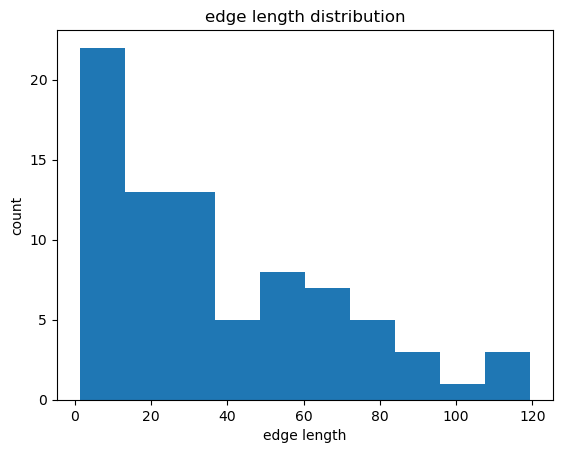

In [46]:
edges = get_edges(boundary_sampler())[0]
plt.hist(edges.cpu().detach().numpy(), bins=10)
plt.title("edge length distribution")
plt.xlabel("edge length")
plt.ylabel("count")
plt.show()

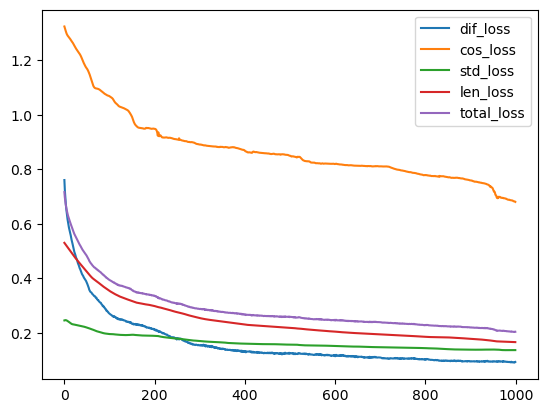

In [47]:
# plt the loss curve
plt.plot(loss_dict["dif_loss"], label="dif_loss")
plt.plot(loss_dict["cos_loss"], label="cos_loss")
plt.plot(loss_dict["std_loss"], label="std_loss")
plt.plot(loss_dict["len_loss"], label="len_loss")
plt.plot(loss_dict["total_loss"], label="total_loss")
plt.legend()